In [1]:
from data_imports import *
from data_clean import data
clean_df = data()

In [2]:
def HGBR_shap(input_data, var, top_n):
    top_n = top_n
    # Seperating the dataframes based on missing O3 values and assinging to variables.
    df_missing = input_data[input_data[var].isnull()]
    df_not_missing = input_data.dropna(subset = [var])

    # Seperating features and target variable.
    X = df_not_missing.drop(columns = [var])
    y = df_not_missing[var]
    
    # Splitting the data into train and testing subsets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Training the model.
    clf = HistGradientBoostingRegressor(random_state = 1)    
    
    clf.fit(X_train, y_train)
    
    explainer = shap.Explainer(clf)
    shap_values = explainer.shap_values(X_test)
        
    shap_importance = np.abs(shap_values).mean(axis=0)
    top_n_indices = np.argsort(shap_importance)[-top_n:][::-1]  # Indices of the top 10 features
    top_n_features = X.columns[top_n_indices]
    return input_data[top_n_features.to_list() + [var]]

In [3]:
def HGBR(input_data, var, shap_i, state):
    # Seperating the dataframes based on missing O3 values and assinging to variables.
    df_missing = input_data[input_data[var].isnull()]
    df_not_missing = input_data.dropna(subset = [var])

    # Seperating features and target variable.
    X = df_not_missing.drop(columns = [var])
    y = df_not_missing[var]
    
    # Splitting the data into train and testing subsets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Training the model.
    clf = HistGradientBoostingRegressor(random_state = 1)    
    
    clf.fit(X_train, y_train)

    # Predictions on the training set.
    y_train_pred = clf.predict(X_train)

    # Predictions on the test set.
    y_test_pred = clf.predict(X_test)
    
    if shap_i == True:
        explainer = shap.Explainer(clf)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    
    # Calculating regression metrics for the training set.
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mse_train ** 0.5
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculating regression metrics for the test set.
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mse_test ** 0.5
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    if state == True:
        # Print training set regression metrics.
        print(f'Training Set - MSE: {mse_train:8.5f}, RMSE: {rmse_train:8.5f}, MAE: {mae_train:8.5f}, R2: {r2_train:8.5f}')

        # Print test set regression metrics.
        print(f'Testing Set  - MSE: {mse_test:8.5f}, RMSE: {rmse_test:8.5f}, MAE: {mae_test:8.5f}, R2: {r2_test:8.5f}')
    else:
        return [[mse_train, rmse_train, mae_train, r2_train], [mse_test, rmse_test, mae_test, r2_test]]

In [4]:
def importance(features):

    feature_range = range(1, features)

    MSE = [[], []]
    RMSE = [[], []]
    MAE = [[], []]
    R2 = [[], []]

    metrics = [MSE, RMSE, MAE, R2]
    metric_names = ['MSE', 'RMSE', 'MAE', 'R2']

    for n in feature_range:

        shap_var_df = HGBR_shap(clean_df, 'O3_ppbV', n)
        HGBR_m = HGBR(shap_var_df, 'O3_ppbV', False, False)
        MSE[0].append(HGBR_m[0][0])
        MSE[1].append(HGBR_m[1][0])
        RMSE[0].append(HGBR_m[0][1])
        RMSE[1].append(HGBR_m[1][1])
        MAE[0].append(HGBR_m[0][2])
        MAE[1].append(HGBR_m[1][2])
        R2[0].append(HGBR_m[0][3])
        R2[1].append(HGBR_m[1][3])

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        axs[i].plot(feature_range, metric[0], marker='o', label=f'Training {metric_names[i]}')
        axs[i].plot(feature_range, metric[1], marker='o', label=f'Testing {metric_names[i]}')
        axs[i].set_title(f'{metric_names[i]} Over Different Configurations')
        axs[i].set_xlabel('Configuration Number')
        axs[i].set_ylabel(metric_names[i])
        axs[i].legend()
        axs[i].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
def time_series(input_data, var, top_n):
    imp_var_df = HGBR_shap(input_data, var, top_n)
    exc_var_df = imp_var_df.drop(columns = [var])
    for variable in exc_var_df:
        plt.figure(figsize=(10, 6))
        plt.plot(imp_var_df[var].values, linestyle='-', color='r', linewidth = 0.1)
        plt.plot(exc_var_df[variable].values, linestyle='-', color='b', linewidth = 0.1)
        plt.title(f'Line Graph of {variable} and {var}')
        plt.xlabel('Index')
        plt.ylabel(variable)
        plt.grid(True)
        plt.show()

In [12]:
import seaborn as sns

def time_series1(input_data, var, top_n):
    imp_var_df = HGBR_shap(input_data, var, top_n)
    exc_var_df = imp_var_df.drop(columns = [var])
    
    sns.set(style="whitegrid")
    
    for variable in exc_var_df:
        fig, ax1 = plt.subplots(figsize = (20, 10))

        var1 = clean_df[var]
        var2 = clean_df[variable]
        
        ax1.plot(var1.values, 'r-', linewidth = 0.1, label = f'{var}')
        ax1.plot(var2.values, 'b-', linewidth = 0.1, label = f'{variable}')

        e = max(var1.max(), var2.max())

        ax1.set_ylim(-1.1 * e, 1.1 * e)

        v2v1 = var2/var1

        ax2 = ax1.twinx()
        ax2.plot(v2v1.values, color = 'black', linewidth = 0.1, label = f'{variable} / {var}')
        ax2.set_ylim(v2v1.min(), 2.1 * v2v1.max())
        
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel(f'{var} and {variable}', fontsize=12)
        ax2.set_ylabel(f'Ratio {variable} / {var}', fontsize=12)
        
        ax1.legend(loc = 'upper left')
        ax2.legend(loc = 'upper right')
        
        plt.title(f'Relationship Between {var} and {variable}', fontsize=14)
        plt.tight_layout()
        plt.show()

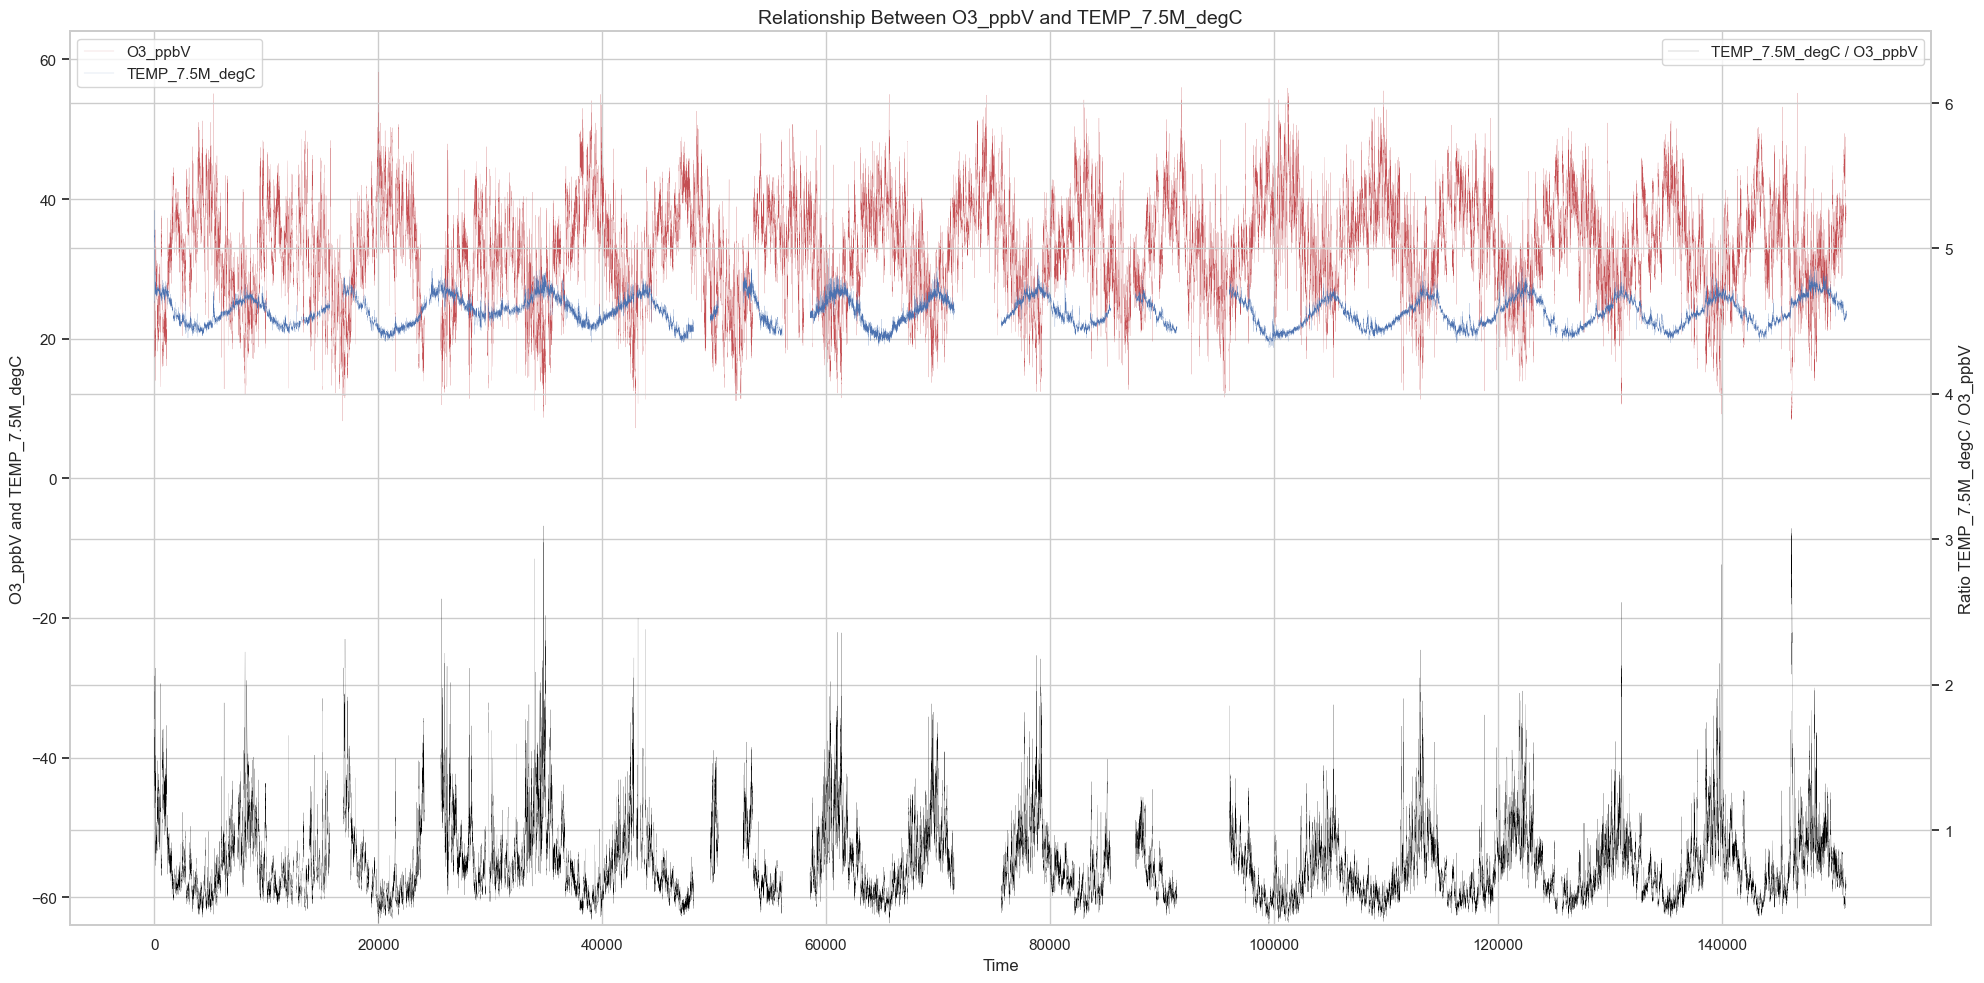

In [13]:
time_series1(clean_df, 'O3_ppbV', 1)

In [30]:
def time_series2(input_data, var, top_n):
    imp_var_df = HGBR_shap(input_data, var, top_n)
    exc_var_df = imp_var_df.drop(columns=[var])
    
    sns.set(style="whitegrid")
    
    for variable in exc_var_df:
        fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

        var1 = clean_df[var]
        var2 = clean_df[variable]
        v2v1 = var2 / var1

        axs[0].plot(var1.values, 'r-', linewidth=0.5, label=f'{var}')
        axs[0].set_ylabel(f'{var}', fontsize=12)
        axs[0].legend(loc='upper right')
        #axs[0].set_title(f'Time Series for {var}', fontsize=14)

        # Plot var2 in the second subplot (axs[1])
        axs[1].plot(var2.values, 'b-', linewidth=0.5, label=f'{variable}')
        axs[1].set_ylabel(f'{variable}', fontsize=12)
        axs[1].legend(loc='upper right')
        #axs[1].set_title(f'Time Series for {variable}', fontsize=14)

        # Plot the ratio (var2/var1) in the third subplot (axs[2])
        axs[2].plot(v2v1.values, 'k-', linewidth=0.5, label=f'{variable} / {var}')
        axs[2].set_ylabel(f'Ratio {variable} / {var}', fontsize=12)
        axs[2].legend(loc='upper right')
        #axs[2].set_title(f'Ratio of {variable} to {var}', fontsize=14)

        # Common X-axis label
        axs[2].set_xlabel('Time', fontsize=12)

        # Adjust layout for better spacing
        plt.suptitle(f'Relationship Between {var} and {variable}', fontsize=20)
        plt.tight_layout()
        plt.subplots_adjust()
        plt.show()

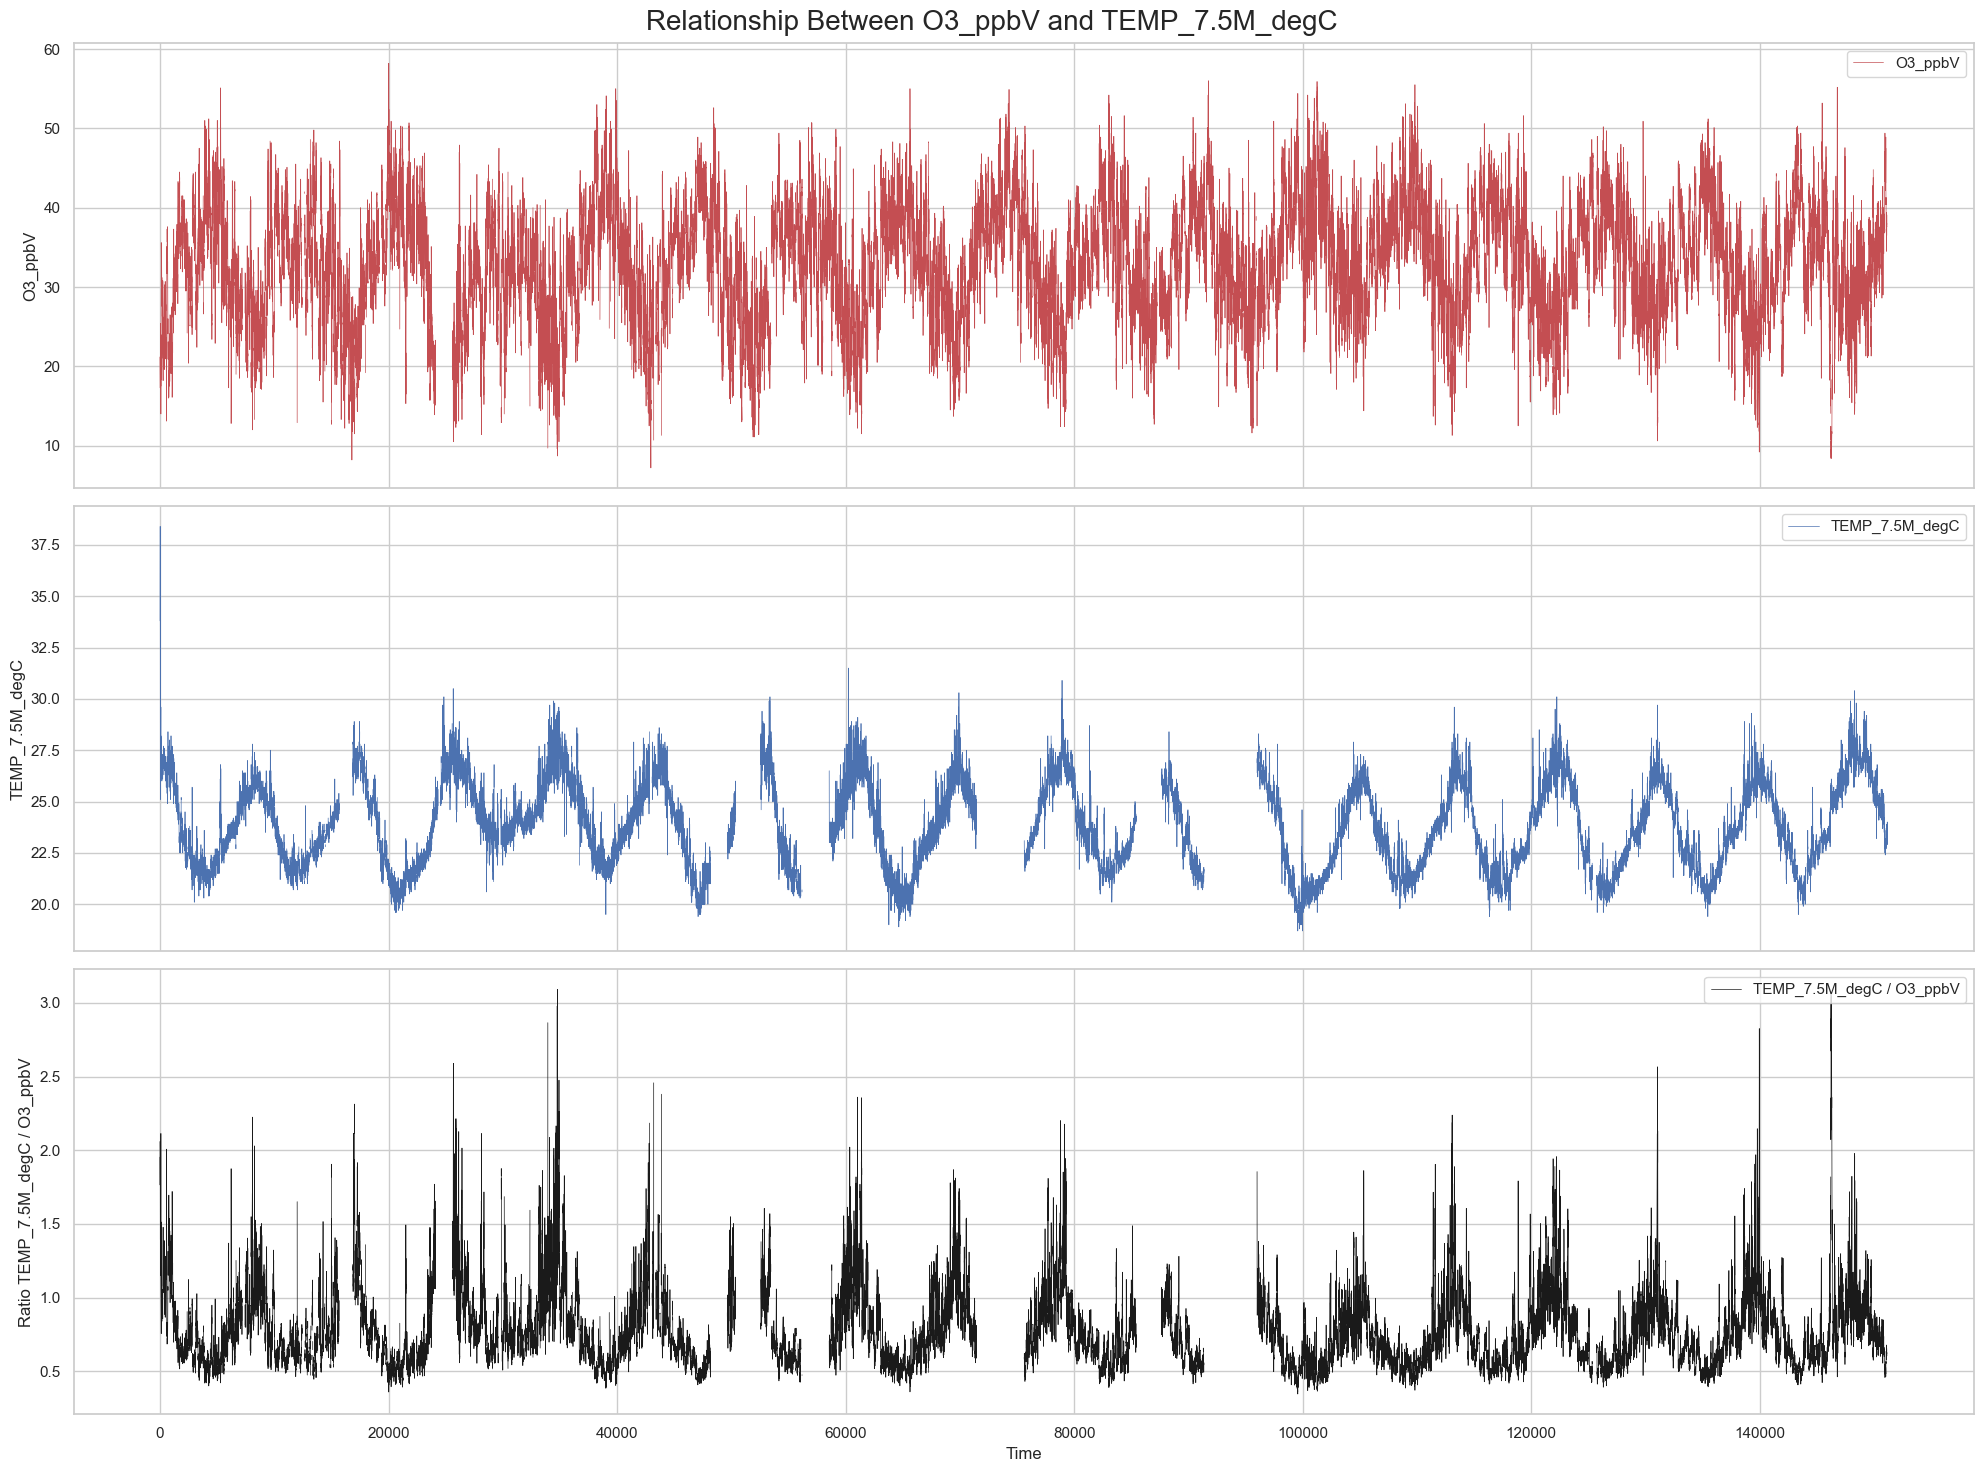

In [31]:
time_series2(clean_df, 'O3_ppbV', 1)